<a href="https://colab.research.google.com/github/chandrusuresh/ReinforcementLearning/blob/master/Ch10-OnPolicyControlwithApproximation/AccessControlQueueTask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm.auto import trange
%matplotlib inline

## Tile Coding

In [75]:
"""
Tile Coding Software version 3.0beta
by Rich Sutton
based on a program created by Steph Schaeffer and others
External documentation and recommendations on the use of this code is available in the 
reinforcement learning textbook by Sutton and Barto, and on the web.
These need to be understood before this code is.

This software is for Python 3 or more.

This is an implementation of grid-style tile codings, based originally on
the UNH CMAC code (see http://www.ece.unh.edu/robots/cmac.htm), but by now highly changed. 
Here we provide a function, "tiles", that maps floating and integer
variables to a list of tiles, and a second function "tiles-wrap" that does the same while
wrapping some floats to provided widths (the lower wrap value is always 0).

The float variables will be gridded at unit intervals, so generalization
will be by approximately 1 in each direction, and any scaling will have 
to be done externally before calling tiles.

Num-tilings should be a power of 2, e.g., 16. To make the offsetting work properly, it should
also be greater than or equal to four times the number of floats.

The first argument is either an index hash table of a given size (created by (make-iht size)), 
an integer "size" (range of the indices from 0), or nil (for testing, indicating that the tile 
coordinates are to be returned without being converted to indices).
"""

basehash = hash

class IHT:
  "Structure to handle collisions"
  def __init__(self, sizeval):
      self.size = sizeval                        
      self.overfullCount = 0
      self.dictionary = {}

  def __str__(self):
      "Prepares a string for printing whenever this object is printed"
      return "Collision table:" + \
              " size:" + str(self.size) + \
              " overfullCount:" + str(self.overfullCount) + \
              " dictionary:" + str(len(self.dictionary)) + " items"

  def count (self):
      return len(self.dictionary)
  
  def fullp (self):
      return len(self.dictionary) >= self.size
  
  def getindex (self, obj, readonly=False):
      d = self.dictionary
      if obj in d: return d[obj]
      elif readonly: return None
      size = self.size
      count = self.count()
      if count >= size:
          if self.overfullCount==0: print('IHT full, starting to allow collisions')
          self.overfullCount += 1
          return basehash(obj) % self.size
      else:
          d[obj] = count
          return count

def hashcoords(coordinates, m, readonly=False):
  if type(m)==IHT: return m.getindex(tuple(coordinates), readonly)
  if type(m)==int: return basehash(tuple(coordinates)) % m
  if m==None: return coordinates

from math import floor, log
from itertools import zip_longest

def tiles (ihtORsize, numtilings, floats, ints=[], readonly=False):
  """returns num-tilings tile indices corresponding to the floats and ints"""
  qfloats = [floor(f*numtilings) for f in floats]
  Tiles = []
  for tiling in range(numtilings):
      tilingX2 = tiling*2
      coords = [tiling]
      b = tiling
      for q in qfloats:
          coords.append( (q + b) // numtilings )
          b += tilingX2
      coords.extend(ints)
      Tiles.append(hashcoords(coords, ihtORsize, readonly))
  return Tiles

## Access Control Queue Task

This is the solution to Example 10.2 in Page-251 of the [Reinforcement Learning book by Sutton & Barto](http://www.incompleteideas.net/book/the-book.html).



In [76]:
maxSize = 2048
iht = IHT(maxSize)
numTilings = 8

alpha = 0.01/float(numTilings)
beta = 0.01
epsilon = 0.1

pEnd = 0.06

num_servers  = 10
num_priority = 4

actions = [0,1]
nA = len(actions)

In [77]:
def mytiles(s,a):
  x = s[0]
  y = s[1]
  scaleFactor_x = float(numTilings)/(num_servers)
  scaleFactor_y = float(numTilings)/(num_priority-1)
  return tiles(iht, numTilings, [x*scaleFactor_x,y*scaleFactor_y],[a])

def move(pos,action):
  free_servers = pos[0]
  priority = pos[1]
  reward = 0
  if action > 0:
    reward = np.power(2.0,float(priority))
    free_servers -= 1
  for i in range(num_servers-free_servers):
    if np.random.uniform(0,1) <= pEnd:
      free_servers += 1
  return reward,[free_servers,np.random.choice(range(num_priority))]

def getActionValue(s,a,wt):
  tile_idx = mytiles(s,a)
  return np.sum(wt[tile_idx])

def target_policy(s,wt,epsilon):
  if s[0] < 1:
    return 0
  Q = np.zeros((nA,))
  for i,a in enumerate(actions):
    Q[i] = getActionValue(s,a,wt)
  action_prob = epsilon/float(nA)*np.ones((nA,))
  maxQ = np.max(Q)
  idx = np.where(Q == maxQ)[0]
  action_prob[idx] += (1-epsilon)/float(len(idx))
  return np.random.choice(range(nA),p=action_prob)

def differential_semigradient_nStep_sarsa(len_queue,alpha,beta,epsilon):
  weights = np.zeros((maxSize,))
  free_servers = 10
  priority = np.random.choice(range(num_priority))
  avg_R = 0
  pos = [free_servers,priority]   
  act_idx = target_policy(pos,weights,epsilon)
  for lq in trange(len_queue,desc="Steps"):  
    reward,next_pos = move(pos,actions[act_idx])
    next_act_idx = target_policy(next_pos,weights,epsilon)

    Q_curr = getActionValue(pos,actions[act_idx],weights)
    Q_next = getActionValue(next_pos,actions[next_act_idx],weights)
    delta = reward - avg_R + Q_next - Q_curr
    avg_R += beta*delta
    tile_idx = mytiles(pos,actions[act_idx])
    weights[tile_idx] += alpha*delta
    pos = next_pos
    act_idx = next_act_idx
  return weights,avg_R

### Differential Semi-Gradient SARSA

In [78]:
len_queue = 2000000
np.random.seed(42)
weights,avgReward = differential_semigradient_nStep_sarsa(len_queue,alpha,beta,epsilon)
print('Average Reward value after ' + str(len_queue) + ' steps = ' + str(avgReward))


Average Reward value after 2000000 steps = 2.734364331641282


In [97]:
free_servers = np.linspace(0,10,11)
priority = np.linspace(1,4,4)

best_action = np.zeros((num_servers+1,num_priority))
diff_Q = np.zeros(best_action.shape)
for i,p in enumerate(free_servers):
  for j,v in enumerate(priority):
    s = [p,v-1]
    best_action[i,j] = target_policy(s,weights,0.0)
    diff_Q[i,j] = getActionValue(s,best_action[i,j],weights)

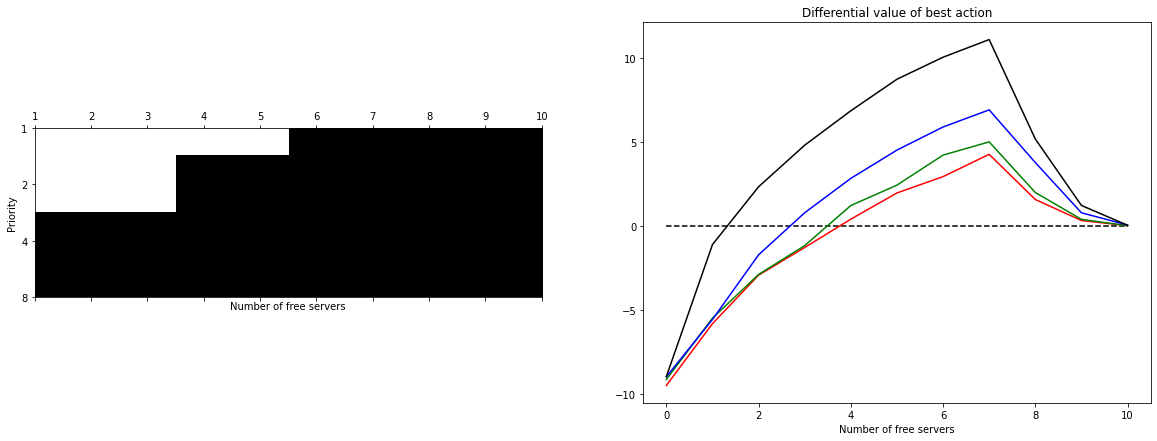

In [100]:
fig,ax = plt.subplots(1,2,figsize=(20,7))
ax[0].matshow(best_action.T,cmap='binary')
ax[0].set_xlabel('Number of free servers')
ax[0].set_ylabel('Priority')
ax[0].set_yticklabels([1,2,4,8])
ax[0].set_xlim([1,10])
ax[0].set_ylim([0,3])
ax[0].invert_yaxis()
ax[1].plot(free_servers,np.zeros(free_servers.shape),'k--')
color = ['red','green','blue','k']
for j in range(num_priority):
  ax[1].plot(free_servers,diff_Q[:,j],color[j])
ax[1].set_title('Value Function')
ax[1].set_xlabel('Number of free servers')
ax[1].set_title('Differential value of best action');